# pbar Variance Metrics

Notebook using _copilot data files. pbar is working properly now, I think I should be able to go end to end on variance metrics, all the way to accurate global maps. Which is massive.

## Housekeeping

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from tqdm.notebook import tqdm
from scipy.ndimage import uniform_filter1d

In [8]:
import os
os.chdir('/home/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [9]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [10]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/ds_p_copilot.nc')
ds_r = xr.open_dataset('/swot/SUM05/amf2288/ds_r_copilot.nc')
ds_pbar = xr.open_dataset('/swot/SUM05/amf2288/ds_pbar_copilot_sentinel.nc')

In [11]:
ds_p_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_p_grid_copilot.nc').drop_vars(['LON_left','LAT_left'])
ds_r_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_r_grid_copilot.nc').drop_vars(['LON_left','LAT_left'])
ds_pbar_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_pbar_grid_copilot.nc').drop_vars(['LON_left','LAT_left'])

## Scale Separations

In [12]:
lfilt = 100

In [13]:
ds_pbar['CT_sort_m'] = ff.ds_filt_single(ds_pbar, lfilt, variable='CT_sort', dim1='PROFILE', dim2='PRESSURE_mean')
print('CT done')
ds_pbar['SA_sort_m'] = ff.ds_filt_single(ds_pbar, lfilt, variable='SA_sort', dim1='PROFILE', dim2='PRESSURE_mean')
print('SA done')
ds_pbar['SPICE_sort_m'] = ff.ds_filt_single(ds_pbar, lfilt, variable='SPICE_sort', dim1='PROFILE', dim2='PRESSURE_mean')
print('SPICE done')

CT done
SA done
SPICE done


In [14]:
ds_pbar['CT_sort_e'] = ds_pbar['CT_sort'] - ds_pbar['CT_sort_m']
print('CT done')
ds_pbar['SA_sort_e'] = ds_pbar['SA_sort'] - ds_pbar['SA_sort_m']
print('SA done')
ds_pbar['SPICE_sort_e'] = ds_pbar['SPICE_sort'] - ds_pbar['SPICE_sort_m']
print('SPICE done')

CT done
SA done
SPICE done


### Mesoscale

In [15]:
ct_e_z2 = ds_pbar['CT_sort_e'].differentiate('PRESSURE_mean')**2
print('CT done')
sa_e_z2 = ds_pbar['SA_sort_e'].differentiate('PRESSURE_mean')**2
print('SA done')
spice_e_z2 = ds_pbar['SPICE_sort_e'].differentiate('PRESSURE_mean')**2
print('SPICE done')

CT done
SA done
SPICE done


In [16]:
ct_e_z2_filt = ff.ds_filt_single(ct_e_z2.to_dataset(name='CT_e_z2'), lfilt, variable='CT_e_z2', dim1='PROFILE', dim2='PRESSURE_mean').rename('CT_e_z2')
print('CT done')
sa_e_z2_filt = ff.ds_filt_single(sa_e_z2.to_dataset(name='SA_e_z2'), lfilt, variable='SA_e_z2', dim1='PROFILE', dim2='PRESSURE_mean').rename('SA_e_z2')
print('SA done')
spice_e_z2_filt = ff.ds_filt_single(spice_e_z2.to_dataset(name='SPICE_e_z2'), lfilt, variable='SPICE_e_z2', dim1='PROFILE', dim2='PRESSURE_mean').rename('SPICE_e_z2')
print('SPICE done')

CT done
SA done
SPICE done


In [17]:
ds_pbar['CT_e_var'] = ct_e_z2_filt
print('CT done')
ds_pbar['SA_e_var'] = sa_e_z2_filt
print('SA done')
ds_pbar['SPICE_e_var'] = spice_e_z2_filt
print('SPICE done')

CT done
SA done
SPICE done


### Microscale

In [18]:
ct_m_z2 = ds_pbar['CT_sort_m'].differentiate('PRESSURE_mean')**2
print('CT done')
sa_m_z2 = ds_pbar['SA_sort_m'].differentiate('PRESSURE_mean')**2
print('SA done')
spice_m_z2 = ds_pbar['SPICE_sort_m'].differentiate('PRESSURE_mean')**2
print('SPICE done')

CT done
SA done
SPICE done


In [19]:
ds_pbar['CT_m_var'] = ct_m_z2
print('CT done')
ds_pbar['SA_m_var'] = sa_m_z2
print('SA done')
ds_pbar['SPICE_m_var'] = spice_m_z2
print('SPICE done')

CT done
SA done
SPICE done


In [24]:
ds_pbar.to_netcdf('/swot/SUM05/amf2288/ds_pbar_var.nc')

## Gridding

In [20]:
def get_ds_gridded(ds, lon_bins, lat_bins, z_coord):
    pbar = tqdm(total=4, desc="Gridding dataset", unit="step")
    
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'LON',
        'LAT',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )
    pbar.update(1)

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'LON_bins': 'LON',
        'LAT_bins': 'LAT',}).rename_vars({
        #'rho_grid': 'density'
        'LON_bins': 'LON',
        'LAT_bins': 'LAT',
        #'rho_grid': 'density'
    })
    pbar.update(1)

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'LON': ('LON', interval_midpoints(ds_binned['LON'].values)),
        'LAT': ('LAT', interval_midpoints(ds_binned['LAT'].values))
    })
    pbar.update(1)

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'LON', 'Y': 'LAT'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'LON', 'left': 'LON_left'},
        'Y': {'center': 'LAT', 'left': 'LAT_left'},
        'Z': {'center': z_coord}
    }, periodic=['X'])
    pbar.update(1)
    
    pbar.close()

    return ds_gridded, grid

In [21]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [22]:
ds_pbar_grid, grid = get_ds_gridded(ds_pbar, lon_bins, lat_bins, 'PRESSURE_mean')

Gridding dataset:   0%|          | 0/4 [00:00<?, ?step/s]

In [23]:
K_rho_p = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc').K.drop_vars(['z_l','z_r','lon_l','lon_r','lat_l','lat_r'])
K_rho_p = K_rho_p.rename({'lat_c':'LAT','lon_c':'LON','z_c':'PRESSURE_mean'})
K_rho_p = K_rho_p.interp(PRESSURE_mean=ds_pbar_grid.PRESSURE_mean, LAT=ds_pbar_grid.LAT, LON=ds_pbar_grid.LON)

### VPR and fractions

In [25]:
ds_pbar_grid['CT_e_VPR'] = K_rho_p * ds_pbar_grid['CT_e_var']
print('CT done')
ds_pbar_grid['SA_e_VPR'] = K_rho_p * ds_pbar_grid['SA_e_var']
print('SA done')
ds_pbar_grid['SPICE_e_VPR'] = K_rho_p * ds_pbar_grid['SPICE_e_var']
print('SPICE done')

CT done
SA done
SPICE done


In [26]:
ds_pbar_grid['CT_m_VPR'] = K_rho_p * ds_pbar_grid['CT_m_var']
print('CT done')
ds_pbar_grid['SA_m_VPR'] = K_rho_p * ds_pbar_grid['SA_m_var']
print('SA done')
ds_pbar_grid['SPICE_m_VPR'] = K_rho_p * ds_pbar_grid['SPICE_m_var']
print('SPICE done')

CT done
SA done
SPICE done


In [27]:
ds_pbar_grid['CT_meso_frac'] = ds_pbar_grid.CT_e_var / (ds_pbar_grid.CT_e_var + ds_pbar_grid.CT_m_var)
print('CT done')
ds_pbar_grid['SA_meso_frac'] = ds_pbar_grid.SA_e_var / (ds_pbar_grid.SA_e_var + ds_pbar_grid.SA_m_var)
print('SA done')
ds_pbar_grid['SPICE_meso_frac'] = ds_pbar_grid.SPICE_e_var / (ds_pbar_grid.SPICE_e_var + ds_pbar_grid.SPICE_m_var)
print('SPICE done')

CT done
SA done
SPICE done


In [28]:
ds_pbar_grid.to_netcdf('/swot/SUM05/amf2288/ds_pbar_grid_var.nc')

## Plots

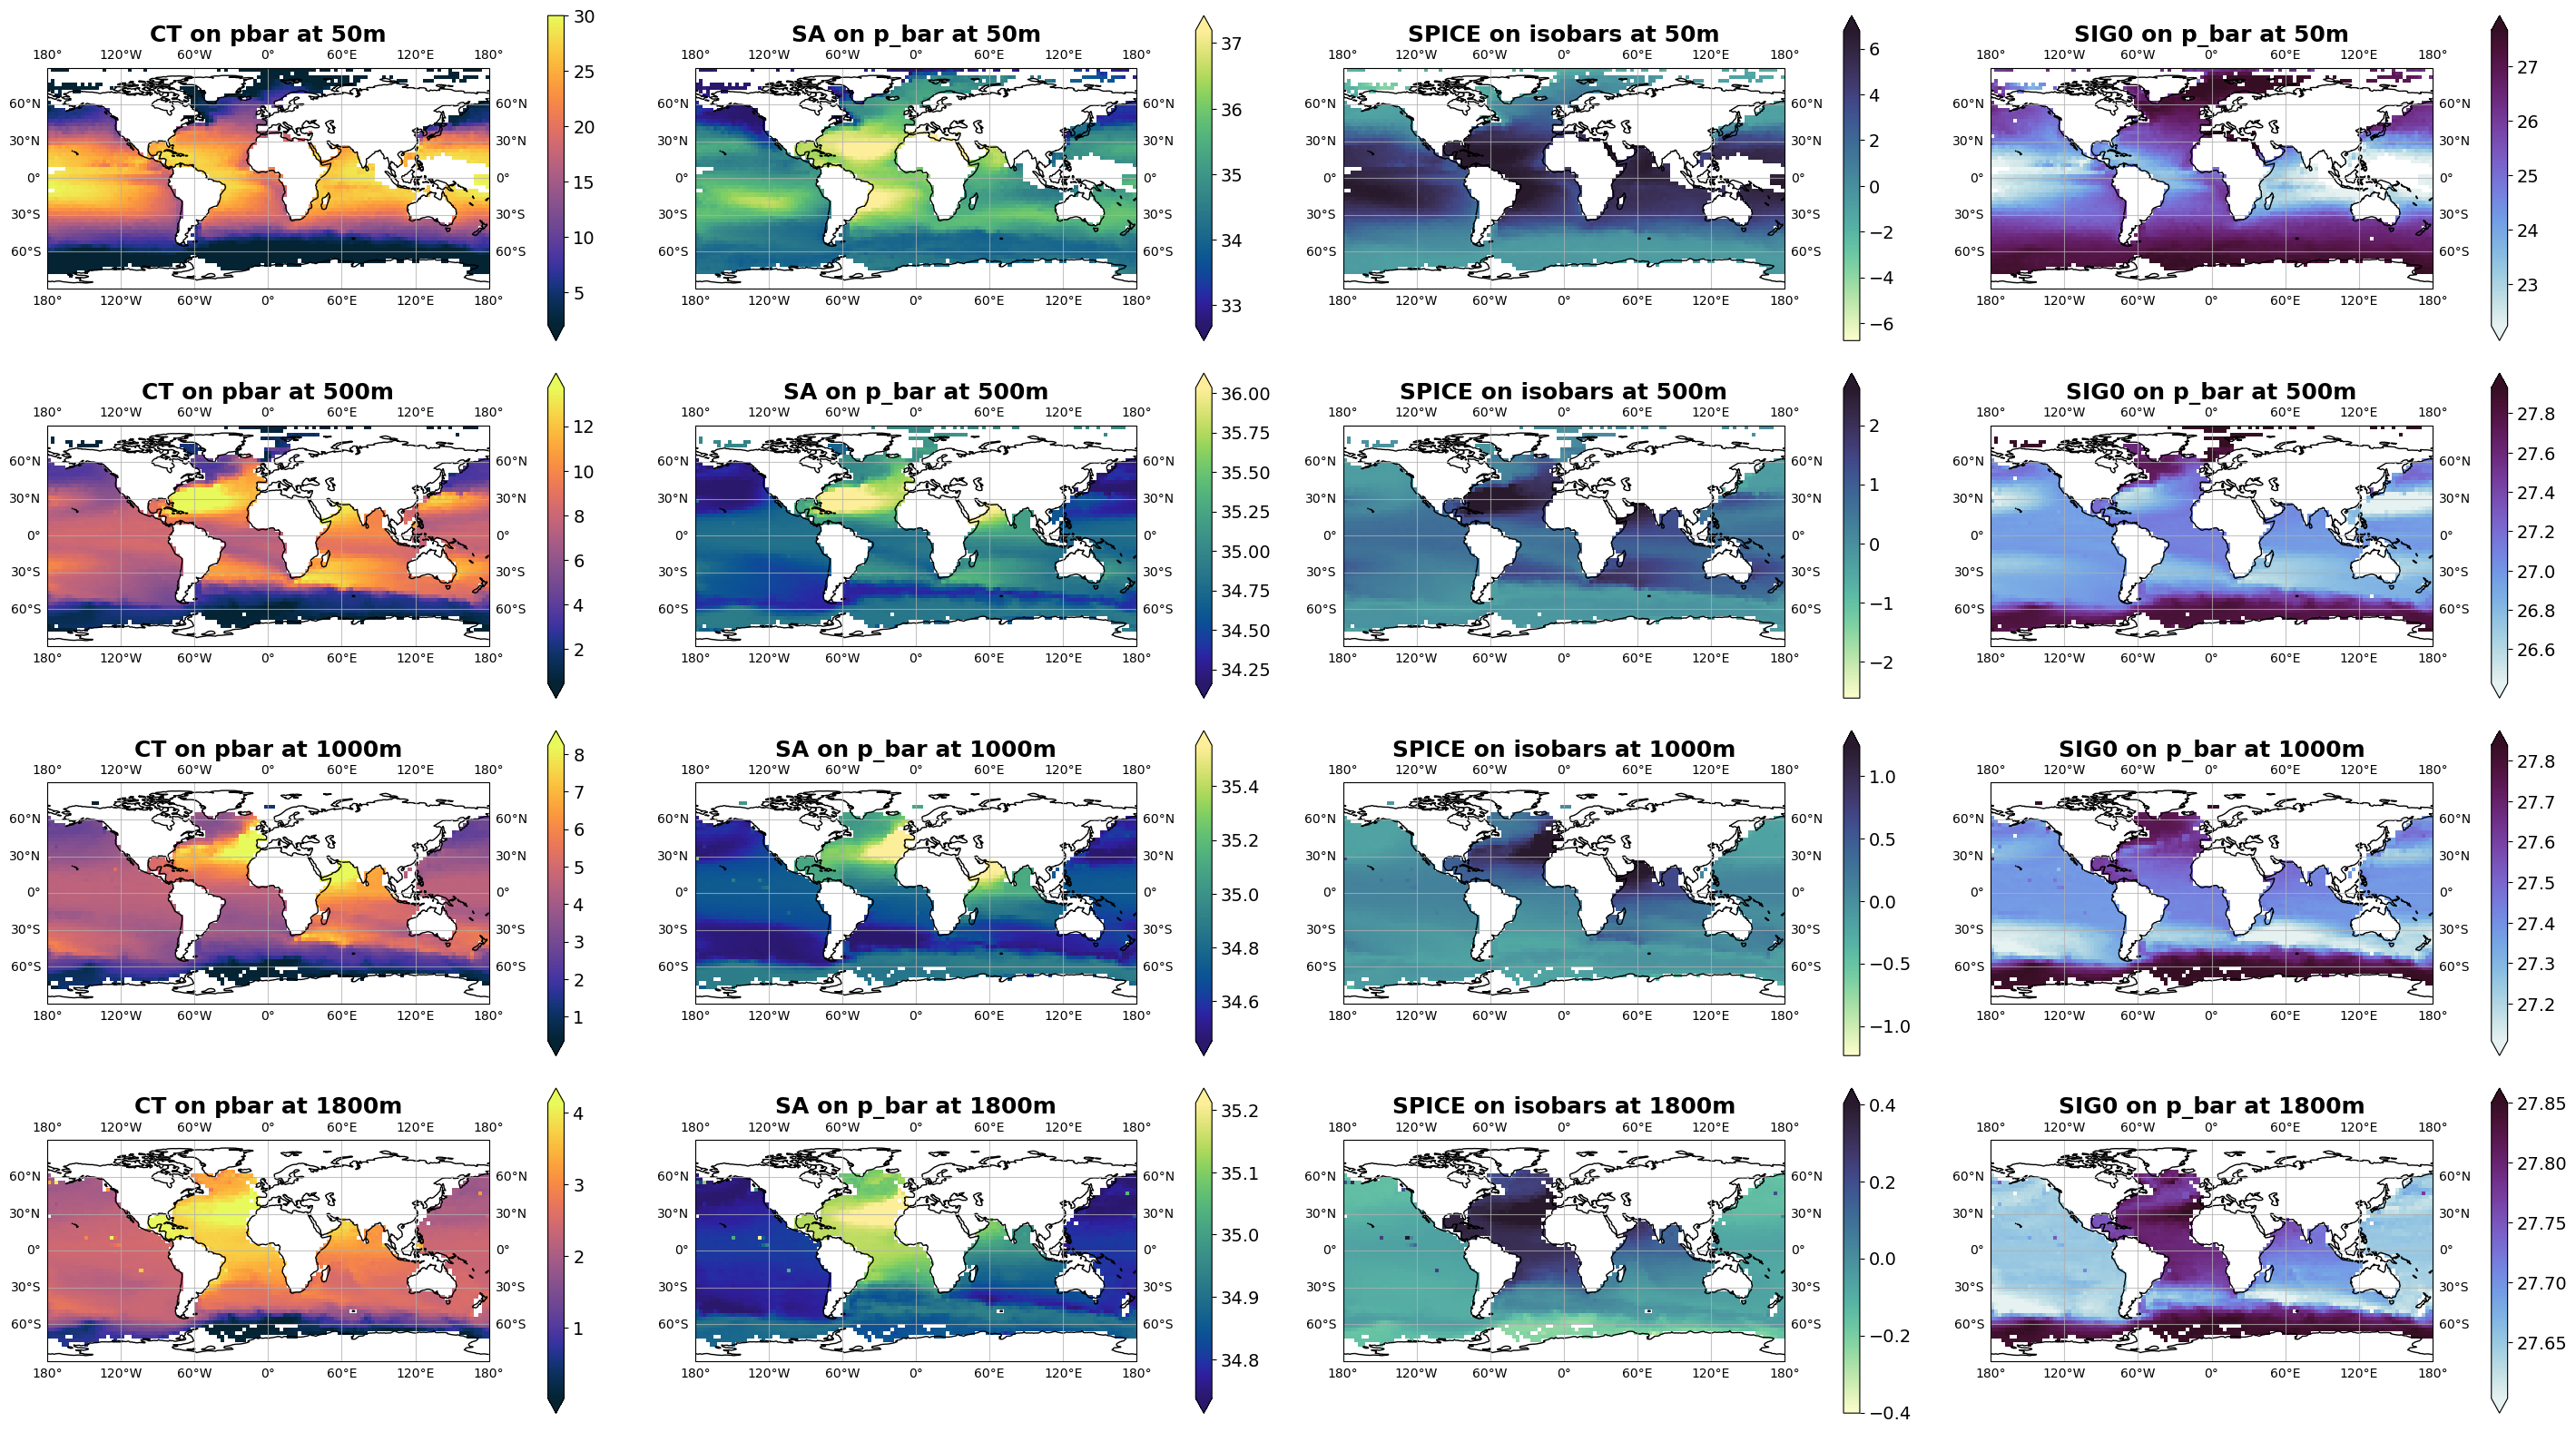

In [49]:
fig = plt.figure(figsize=(36, 20))
depth1, depth2, depth3, depth4 = 50, 500, 1000, 1800
shrink, pad = 1, 0.1

ax1 = plt.subplot(4, 4, 1, projection=ccrs.PlateCarree())
ds_pbar_grid.CT_sort.sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON', y='LAT', cmap=cmo.thermal, vmin=2, vmax=30, ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax1.coastlines()
ax1.gridlines(draw_labels=True, alpha=0.75)
ax1.set_title(f'CT on pbar at {depth1}m', fontweight='bold')

ax2 = plt.subplot(4, 4, 2, projection=ccrs.PlateCarree())
ds_pbar_grid.SA_sort.sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON', y='LAT', cmap=cmo.haline, robust=True, ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax2.coastlines()
ax2.gridlines(draw_labels=True, alpha=0.75)
ax2.set_title(f'SA on p_bar at {depth1}m', fontweight='bold')

ax3 = plt.subplot(4, 4, 3, projection=ccrs.PlateCarree())
ds_pbar_grid.SPICE_sort.sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON', y='LAT', cmap=cmo.deep, robust=True, ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax3.coastlines()
ax3.gridlines(draw_labels=True, alpha=0.75)
ax3.set_title(f'SPICE on isobars at {depth1}m', fontweight='bold')

ax4 = plt.subplot(4, 4, 4, projection=ccrs.PlateCarree())
ds_pbar_grid.DENSITY.sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON', y='LAT', cmap=cmo.dense, robust=True, ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax4.coastlines()
ax4.gridlines(draw_labels=True, alpha=0.75)
ax4.set_title(f'SIG0 on p_bar at {depth1}m', fontweight='bold')

ax5 = plt.subplot(4, 4, 5, projection=ccrs.PlateCarree())
ds_pbar_grid.CT_sort.sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON', y='LAT', cmap=cmo.thermal, robust=True, ax=ax5, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax5.coastlines()
ax5.gridlines(draw_labels=True, alpha=0.75)
ax5.set_title(f'CT on pbar at {depth2}m', fontweight='bold')

ax6 = plt.subplot(4, 4, 6, projection=ccrs.PlateCarree())
ds_pbar_grid.SA_sort.sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON', y='LAT', cmap=cmo.haline, robust=True, ax=ax6, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax6.coastlines()
ax6.gridlines(draw_labels=True, alpha=0.75)
ax6.set_title(f'SA on p_bar at {depth2}m', fontweight='bold')

ax7 = plt.subplot(4, 4, 7, projection=ccrs.PlateCarree())
ds_pbar_grid.SPICE_sort.sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON', y='LAT', cmap=cmo.deep, robust=True, ax=ax7, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax7.coastlines()
ax7.gridlines(draw_labels=True, alpha=0.75)
ax7.set_title(f'SPICE on isobars at {depth2}m', fontweight='bold')

ax8 = plt.subplot(4, 4, 8, projection=ccrs.PlateCarree())
ds_pbar_grid.DENSITY.sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON', y='LAT', cmap=cmo.dense, robust=True, ax=ax8, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax8.coastlines()
ax8.gridlines(draw_labels=True, alpha=0.75)
ax8.set_title(f'SIG0 on p_bar at {depth2}m', fontweight='bold')

ax9 = plt.subplot(4, 4, 9, projection=ccrs.PlateCarree())
ds_pbar_grid.CT_sort.sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON', y='LAT', cmap=cmo.thermal, robust=True, ax=ax9, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax9.coastlines()
ax9.gridlines(draw_labels=True, alpha=0.75)
ax9.set_title(f'CT on pbar at {depth3}m', fontweight='bold')

ax10 = plt.subplot(4, 4, 10, projection=ccrs.PlateCarree())
ds_pbar_grid.SA_sort.sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON', y='LAT', cmap=cmo.haline, robust=True, ax=ax10, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax10.coastlines()
ax10.gridlines(draw_labels=True, alpha=0.75)
ax10.set_title(f'SA on p_bar at {depth3}m', fontweight='bold')

ax11 = plt.subplot(4, 4, 11, projection=ccrs.PlateCarree())
ds_pbar_grid.SPICE_sort.sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON', y='LAT', cmap=cmo.deep, robust=True, ax=ax11, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax11.coastlines()
ax11.gridlines(draw_labels=True, alpha=0.75)
ax11.set_title(f'SPICE on isobars at {depth3}m', fontweight='bold')

ax12 = plt.subplot(4, 4, 12, projection=ccrs.PlateCarree())
ds_pbar_grid.DENSITY.sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON', y='LAT', cmap=cmo.dense, robust=True, ax=ax12, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax12.coastlines()
ax12.gridlines(draw_labels=True, alpha=0.75)
ax12.set_title(f'SIG0 on p_bar at {depth3}m', fontweight='bold')

ax13 = plt.subplot(4, 4, 13, projection=ccrs.PlateCarree())
ds_pbar_grid.CT_sort.sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON', y='LAT', cmap=cmo.thermal, robust=True, ax=ax13, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax13.coastlines()
ax13.gridlines(draw_labels=True, alpha=0.75)
ax13.set_title(f'CT on pbar at {depth4}m', fontweight='bold')

ax14 = plt.subplot(4, 4, 14, projection=ccrs.PlateCarree())
ds_pbar_grid.SA_sort.sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON', y='LAT', cmap=cmo.haline, robust=True, ax=ax14, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax14.coastlines()
ax14.gridlines(draw_labels=True, alpha=0.75)
ax14.set_title(f'SA on p_bar at {depth4}m', fontweight='bold')

ax15 = plt.subplot(4, 4, 15, projection=ccrs.PlateCarree())
ds_pbar_grid.SPICE_sort.sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON', y='LAT', cmap=cmo.deep, robust=True, ax=ax15, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax15.coastlines()
ax15.gridlines(draw_labels=True, alpha=0.75)
ax15.set_title(f'SPICE on isobars at {depth4}m', fontweight='bold')

ax16 = plt.subplot(4, 4, 16, projection=ccrs.PlateCarree())
ds_pbar_grid.DENSITY.sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON', y='LAT', cmap=cmo.dense, robust=True, ax=ax16, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax16.coastlines()
ax16.gridlines(draw_labels=True, alpha=0.75)
ax16.set_title(f'SIG0 on p_bar at {depth4}m', fontweight='bold')

plt.subplots_adjust(hspace=0.1, wspace=0.1)

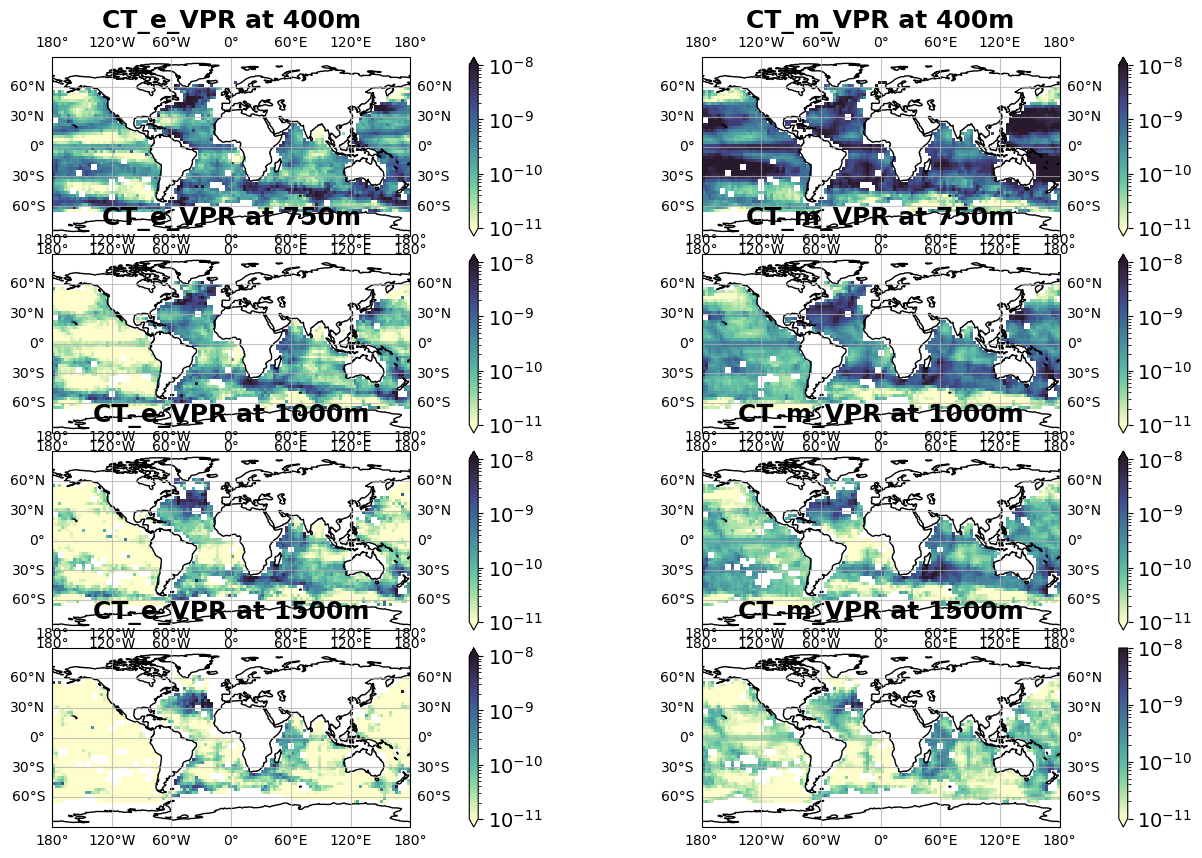

In [53]:
fig = plt.figure(figsize=(16, 10))

depth1, depth2, depth3, depth4 = 400, 750, 1000, 1500
shrink, pad = 1, 0.1
e_norm, m_norm = colors.LogNorm(vmin=1e-11, vmax=1e-8), colors.LogNorm(vmin=1e-11, vmax=1e-8)
var_cmap = cmo.deep
var1 = 'CT_e_VPR'
var2 = 'CT_m_VPR'

ax1 = plt.subplot(4,2,1, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax1.coastlines()
ax1.gridlines(draw_labels=True, alpha=0.75)
ax1.set_title(f'{var1} at {depth1}m', fontweight='bold')

ax2 = plt.subplot(4,2,2, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax2.coastlines()
ax2.gridlines(draw_labels=True, alpha=0.75)
ax2.set_title(f'{var2} at {depth1}m', fontweight='bold')

ax3 = plt.subplot(4,2,3, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax3.coastlines()
ax3.gridlines(draw_labels=True, alpha=0.75)
ax3.set_title(f'{var1} at {depth2}m', fontweight='bold')

ax4 = plt.subplot(4,2,4, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax4.coastlines()
ax4.gridlines(draw_labels=True, alpha=0.75)
ax4.set_title(f'{var2} at {depth2}m', fontweight='bold')

ax5 = plt.subplot(4,2,5, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax5, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax5.coastlines()
ax5.gridlines(draw_labels=True, alpha=0.75)
ax5.set_title(f'{var1} at {depth3}m', fontweight='bold')

ax6 = plt.subplot(4,2,6, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax6, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax6.coastlines()
ax6.gridlines(draw_labels=True, alpha=0.75)
ax6.set_title(f'{var2} at {depth3}m', fontweight='bold')

ax7 = plt.subplot(4,2,7, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax7, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax7.coastlines()
ax7.gridlines(draw_labels=True, alpha=0.75)
ax7.set_title(f'{var1} at {depth4}m', fontweight='bold')

ax8 = plt.subplot(4,2,8, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax8, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax8.coastlines()
ax8.gridlines(draw_labels=True, alpha=0.75)
ax8.set_title(f'{var2} at {depth4}m', fontweight='bold')

plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [ ]:
fig = plt.figure(figsize=(16, 14))

depth1, depth2, depth3, depth4 = 50, 500, 1000, 1800
shrink, pad = 0.6, 0.02
e_norm, m_norm = colors.LogNorm(vmin=1e-11, vmax=1e-8), colors.LogNorm(vmin=1e-11, vmax=1e-8)
var_cmap = cmo.deep
var1 = 'SA_e_VPR'
var2 = 'SA_m_VPR'

ax1 = plt.subplot(4,2,1, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax1.coastlines()
ax1.gridlines(draw_labels=True, alpha=0.75)
ax1.set_title(f'{var1} at {depth1}m', fontweight='bold')

ax2 = plt.subplot(4,2,2, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax2.coastlines()
ax2.gridlines(draw_labels=True, alpha=0.75)
ax2.set_title(f'{var2} at {depth1}m', fontweight='bold')

ax3 = plt.subplot(4,2,3, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax3.coastlines()
ax3.gridlines(draw_labels=True, alpha=0.75)
ax3.set_title(f'{var1} at {depth2}m', fontweight='bold')

ax4 = plt.subplot(4,2,4, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax4.coastlines()
ax4.gridlines(draw_labels=True, alpha=0.75)
ax4.set_title(f'{var2} at {depth2}m', fontweight='bold')

ax5 = plt.subplot(4,2,5, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax5, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax5.coastlines()
ax5.gridlines(draw_labels=True, alpha=0.75)
ax5.set_title(f'{var1} at {depth3}m', fontweight='bold')

ax6 = plt.subplot(4,2,6, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax6, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax6.coastlines()
ax6.gridlines(draw_labels=True, alpha=0.75)
ax6.set_title(f'{var2} at {depth3}m', fontweight='bold')

ax7 = plt.subplot(4,2,7, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax7, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax7.coastlines()
ax7.gridlines(draw_labels=True, alpha=0.75)
ax7.set_title(f'{var1} at {depth4}m', fontweight='bold')

ax8 = plt.subplot(4,2,8, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax8, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax8.coastlines()
ax8.gridlines(draw_labels=True, alpha=0.75)
ax8.set_title(f'{var2} at {depth4}m', fontweight='bold')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16, 14))

depth1, depth2, depth3, depth4 = 50, 500, 1000, 1800
shrink, pad = 0.6, 0.02
e_norm, m_norm = colors.LogNorm(vmin=1e-11, vmax=1e-8), colors.LogNorm(vmin=1e-11, vmax=1e-8)
var_cmap = cmo.deep
var1 = 'SPICE_e_VPR'
var2 = 'SPICE_m_VPR'

ax1 = plt.subplot(4,2,1, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax1.coastlines()
ax1.gridlines(draw_labels=True, alpha=0.75)
ax1.set_title(f'{var1} at {depth1}m', fontweight='bold')

ax2 = plt.subplot(4,2,2, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax2.coastlines()
ax2.gridlines(draw_labels=True, alpha=0.75)
ax2.set_title(f'{var2} at {depth1}m', fontweight='bold')

ax3 = plt.subplot(4,2,3, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax3.coastlines()
ax3.gridlines(draw_labels=True, alpha=0.75)
ax3.set_title(f'{var1} at {depth2}m', fontweight='bold')

ax4 = plt.subplot(4,2,4, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax4.coastlines()
ax4.gridlines(draw_labels=True, alpha=0.75)
ax4.set_title(f'{var2} at {depth2}m', fontweight='bold')

ax5 = plt.subplot(4,2,5, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax5, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax5.coastlines()
ax5.gridlines(draw_labels=True, alpha=0.75)
ax5.set_title(f'{var1} at {depth3}m', fontweight='bold')

ax6 = plt.subplot(4,2,6, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax6, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax6.coastlines()
ax6.gridlines(draw_labels=True, alpha=0.75)
ax6.set_title(f'{var2} at {depth3}m', fontweight='bold')

ax7 = plt.subplot(4,2,7, projection=ccrs.PlateCarree())
ds_pbar_grid[var1].sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=e_norm, ax=ax7, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax7.coastlines()
ax7.gridlines(draw_labels=True, alpha=0.75)
ax7.set_title(f'{var1} at {depth4}m', fontweight='bold')

ax8 = plt.subplot(4,2,8, projection=ccrs.PlateCarree())
ds_pbar_grid[var2].sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON',y='LAT',cmap=var_cmap, robust=True, norm=m_norm, ax=ax8, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': shrink, 'pad': pad, 'label': ''})
ax8.coastlines()
ax8.gridlines(draw_labels=True, alpha=0.75)
ax8.set_title(f'{var2} at {depth4}m', fontweight='bold')

plt.tight_layout()

TypeError: Bbox.from_bounds() missing 2 required positional arguments: 'width' and 'height'